In [1]:
# Notebook to import CSV output from LISA (manual annotation)
# and compare to masks generated from segment-anything

import pandas as pd
from vesicle_picker import funcs_mrcio, preprocess, generate_masks, postprocess, helpers
import matplotlib.pyplot as plt
import numpy as np
import copy
from tqdm import tqdm, trange
from cryosparc.tools import downsample
import datetime
import time

/tmp/ipykernel_30991/1004578838.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Read in the file
manual_picks = pd.read_csv('/home/rkarimi/vesicle-picker-dev/vesicles_240/bounding_boxes/first_50_pass2.csv')

# Find the centers
manual_picks['x_center'] = manual_picks['x'] + manual_picks['width']/2
manual_picks['y_center'] = manual_picks['y'] + manual_picks['height']/2

# Compute the area
manual_picks['area'] = manual_picks['width'] + manual_picks['height']

# Extract the UIDs
manual_picks['uid'] = manual_picks['file_name'].apply(lambda x: x.split("/")[-1][:-4])

In [3]:
# Define an MRC import function
def import_mrc(filename):
    """Use funcs_mrcio to open a specified .mrc file"""
    # Read the .mrc file in binary
    micrograph = open(filename,'rb')
    
    # Use funcs_mrcio to extract image array and rescale values to lie between [-1, 1]
    image = funcs_mrcio.irdsec_opened(micrograph,0)
    
    # Use funcs_mrcio to extract header info
    header = funcs_mrcio.irdhdr_opened(micrograph)
    
    # Return the rescaled image and header
    return image, header

In [4]:
# Initialize the model
model = generate_masks.initialize_model(model_weights_path = "../sam_vit_h_4b8939.pth", model_type='vit_h', device='cuda:0')

In [19]:
# Loop over the images used for manual annotation

# Define run parameters
downsample_factor = 4
lowpass_mode = 'bilateral'
d = 20
sigmaColor = 130
sigmaSpace = 70
pred_iou_thresh = 0.9
stability_score_thresh = 0.9
psize=1.03

# # Define run parameters for Gaussian blur
# downsample_factor = 4
# lowpass_mode = 'gaussian'
# kernel_size=(21,21)
# sigma=0
# pred_iou_thresh = 0.9
# stability_score_thresh = 0.9
# psize=1.03

# Make some lists that exist outside of the loop to collect the information from the run
precision_master = list()
recall_master = list()
runtime_master = list()

# For all unique file IDs in the manual pick dataset:
for i in tqdm(manual_picks['file_id'].unique()):
#for i in trange(1):
    # Extract the manual picks from that file
    these_manual_picks = manual_picks[manual_picks['file_id'] == i]
    # Construct the filepath for that raw MRC image
    filepath = "/home/rkarimi/vesicle-picker-dev/vesicles_240/raw_mrc/"+these_manual_picks.iloc[0]['uid']+".mrc"
    # Import the image
    image_fullres, header = import_mrc(filepath)
    
    # Use the preprocess module to get micrograph ready for segmentation
    preprocessed_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                               downsample=downsample_factor, 
                                                               lowpass_mode=lowpass_mode,
                                                               d=d,
                                                               sigmaColor=sigmaColor,
                                                               sigmaSpace=sigmaSpace)

    # # Use the preprocess module to get micrograph ready for segmentation -gaussian
    # preprocessed_micrograph = preprocess.preprocess_micrograph(image_fullres, 
    #                                                            downsample_factor=downsample_factor, 
    #                                                            lowpass_mode=lowpass_mode,
    #                                                            ksize=kernel_size,
    #                                                            sigmaX=sigma)

    print("Generating masks...")

    # Downsample the image
    #image = downsample(image_fullres, downsample_factor)
    start_time = time.time()
    # Generate masks with user-optimized parameters
    masks = generate_masks.generate_masks(preprocessed_micrograph, model, 
                                          points_per_side=36,
                                          points_per_batch=32,
                                          pred_iou_thresh=pred_iou_thresh,
                                          stability_score_thresh=stability_score_thresh,
                                          crop_n_layers=1,
                                          crop_n_points_downscale_factor=2,
                                          crop_nms_thresh=0.1,
                                          min_mask_region_area=100,
                                          psize=1.03,
                                          downsample=downsample_factor)
    end_time = time.time()
    runtime = end_time - start_time
    runtime_master.append(runtime)
    print(runtime)

    # # Use the postprocess module to compute statistics on the vesicles
    # postprocessed_masks = postprocess.postprocess_masks(masks, 
    #                               [postprocess.find_mask_intensity, postprocess.find_contour, postprocess.find_roundness, postprocess.fit_ellipse], 
    #                               preprocessed_micrograph)
    
    # # Filter these vesicles based on min and max values recorded in 'filters.ini'
    # filtered_masks = postprocess.apply_filters(postprocessed_masks, "filters_sigmac.ini")
        
    # Visualize the generated masks
    # Create a figure with three subplots arranged in a row
    # fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # # Plot the first image in the first subplot
    # axes[0].imshow(image_fullres, cmap="Greys_r")
    # axes[0].set_title('Preprocessed Micrograph')
    
    # # Plot the second image in the second subplot
    # axes[1].imshow(helpers.sum_masks(masks, 'segmentation'))
    # axes[1].set_title('SA Masks')
    
    # # Plot the third image in the third subplot
    # axes[2].imshow(helpers.sum_masks(filtered_masks, 'segmentation'))
    # axes[2].set_title('Filtered SA Masks')
    
    # # Remove axis labels and ticks
    # for ax in axes:
    #     ax.axis('off')
    
    # # Show the side-by-side plot
    # plt.show()

    SA_IOUs = list()
    
    for mask in masks:

        # Loop over the masks and for each mask, calculate the IOU with the nearest manual bounding box
        x_center = downsample_factor*mask['bbox'][0]/4 + downsample_factor*mask['bbox'][2]/8
        y_center = downsample_factor*mask['bbox'][1]/4 + downsample_factor*mask['bbox'][3]/8
        
        # Extract the manual bounding box closest to the center
        manual_index = np.argmin((x_center - these_manual_picks['x_center'])**2 + (y_center - these_manual_picks['y_center'])**2)
        this_row = these_manual_picks.iloc[manual_index]

        # Calculate the IOU with that bounding box
        
        # The SA pick
        x1, y1, w1, h1 = downsample_factor*mask['bbox'][0]/4, downsample_factor*mask['bbox'][1]/4, downsample_factor*mask['bbox'][2]/4, downsample_factor*mask['bbox'][3]/4
        # The manual pick
        x2, y2, w2, h2 = this_row['x'], this_row['y'], this_row['width'], this_row['height']

        # Calculate the (x, y)-coordinates of the intersection rectangle
        xA = max(x1, x2)
        yA = max(y1, y2)
        xB = min(x1+w1, x2+w2)
        yB = min(y1+h1, y2+h2)
        
        # Calculate the area of the intersection
        interArea = max(0, xB - xA) * max(0, yB - yA)
        
        # Compute the area of both the prediction and ground-truth rectangles
        box1Area = w1 * h1
        box2Area = w2 * h2
        
        # Compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(box1Area + box2Area - interArea)
        
        SA_IOUs.append(iou)

    #print(SA_IOUs)

    # Calculate the number of true positives
    true_masks = len([iou for iou in SA_IOUs if iou >= 0.5])

    # Calculate the total number of SA masks
    all_masks_SA = len(SA_IOUs)

    # Calculate the total number of manual masks
    all_masks_manual = len(these_manual_picks)

    # Update the master lists
    if all_masks_SA == 0:
        precision_master.append(np.nan)
    else:
        precision_master.append((true_masks/all_masks_SA))
    recall_master.append((true_masks/all_masks_manual))

    # Print the precision and recall
    print("Precision: "+str(true_masks/all_masks_SA))
    print("Recall: "+str(true_masks/all_masks_manual))
    

  0%|                                                    | 0/50 [00:00<?, ?it/s]

Generating masks...


  2%|▉                                           | 1/50 [00:06<05:15,  6.45s/it]

6.214971542358398
Precision: 0.41935483870967744
Recall: 0.9069767441860465
Generating masks...


  4%|█▊                                          | 2/50 [00:12<05:06,  6.38s/it]

6.086501121520996
Precision: 0.40816326530612246
Recall: 0.975609756097561
Generating masks...


  6%|██▋                                         | 3/50 [00:19<04:56,  6.31s/it]

6.005996942520142
Precision: 0.5068493150684932
Recall: 0.925
Generating masks...


  8%|███▌                                        | 4/50 [00:25<04:49,  6.30s/it]

6.042344570159912
Precision: 0.5753424657534246
Recall: 0.875
Generating masks...


 10%|████▍                                       | 5/50 [00:31<04:43,  6.30s/it]

6.064033269882202
Precision: 0.44565217391304346
Recall: 0.9111111111111111
Generating masks...


 12%|█████▎                                      | 6/50 [00:37<04:37,  6.31s/it]

6.104423761367798
Precision: 0.4631578947368421
Recall: 0.9361702127659575
Generating masks...


 14%|██████▏                                     | 7/50 [00:44<04:30,  6.30s/it]

6.051300525665283
Precision: 0.5454545454545454
Recall: 0.9130434782608695
Generating masks...


 16%|███████                                     | 8/50 [00:50<04:24,  6.29s/it]

6.044711589813232
Precision: 0.3888888888888889
Recall: 0.9722222222222222
Generating masks...


 18%|███████▉                                    | 9/50 [00:57<04:22,  6.39s/it]

6.381892681121826
Precision: 0.39325842696629215
Recall: 0.875
Generating masks...


 20%|████████▌                                  | 10/50 [01:03<04:17,  6.43s/it]

6.284584045410156
Precision: 0.5180722891566265
Recall: 1.0
Generating masks...


 22%|█████████▍                                 | 11/50 [01:09<04:10,  6.41s/it]

6.150892734527588
Precision: 0.5588235294117647
Recall: 0.95
Generating masks...


 24%|██████████▎                                | 12/50 [01:16<04:01,  6.34s/it]

5.954543113708496
Precision: 0.5172413793103449
Recall: 0.8571428571428571
Generating masks...


 26%|███████████▏                               | 13/50 [01:22<03:55,  6.37s/it]

6.184713840484619
Precision: 0.375
Recall: 0.8918918918918919
Generating masks...


 28%|████████████                               | 14/50 [01:28<03:49,  6.38s/it]

6.164534330368042
Precision: 0.5595238095238095
Recall: 0.9215686274509803
Generating masks...


 30%|████████████▉                              | 15/50 [01:35<03:42,  6.35s/it]

6.040700197219849
Precision: 0.4383561643835616
Recall: 0.8888888888888888
Generating masks...


 32%|█████████████▊                             | 16/50 [01:41<03:35,  6.34s/it]

6.087944746017456
Precision: 0.3411764705882353
Recall: 1.0
Generating masks...


 34%|██████████████▌                            | 17/50 [01:47<03:28,  6.31s/it]

6.016156911849976
Precision: 0.581081081081081
Recall: 0.9555555555555556
Generating masks...


 36%|███████████████▍                           | 18/50 [01:54<03:24,  6.38s/it]

6.307581186294556
Precision: 0.5119047619047619
Recall: 0.9555555555555556
Generating masks...


 38%|████████████████▎                          | 19/50 [02:00<03:18,  6.39s/it]

6.174590826034546
Precision: 0.4794520547945205
Recall: 0.9210526315789473
Generating masks...


 40%|█████████████████▏                         | 20/50 [02:07<03:11,  6.37s/it]

6.106512784957886
Precision: 0.4025974025974026
Recall: 0.8378378378378378
Generating masks...


 42%|██████████████████                         | 21/50 [02:13<03:05,  6.39s/it]

6.202015161514282
Precision: 0.3373493975903614
Recall: 0.9655172413793104
Generating masks...


 44%|██████████████████▉                        | 22/50 [02:19<02:59,  6.39s/it]

6.172145128250122
Precision: 0.48148148148148145
Recall: 0.975
Generating masks...


 46%|███████████████████▊                       | 23/50 [02:26<02:52,  6.37s/it]

6.098781585693359
Precision: 0.4457831325301205
Recall: 0.925
Generating masks...


 48%|████████████████████▋                      | 24/50 [02:32<02:45,  6.38s/it]

6.1532142162323
Precision: 0.5
Recall: 0.9111111111111111
Generating masks...


 50%|█████████████████████▌                     | 25/50 [02:39<02:39,  6.37s/it]

6.137993574142456
Precision: 0.37777777777777777
Recall: 0.918918918918919
Generating masks...


 52%|██████████████████████▎                    | 26/50 [02:45<02:32,  6.35s/it]

6.055973768234253
Precision: 0.3132530120481928
Recall: 1.0
Generating masks...


 54%|███████████████████████▏                   | 27/50 [02:51<02:26,  6.37s/it]

6.18033504486084
Precision: 0.4946236559139785
Recall: 0.9387755102040817
Generating masks...


 56%|████████████████████████                   | 28/50 [02:58<02:20,  6.36s/it]

6.124993801116943
Precision: 0.43333333333333335
Recall: 1.0
Generating masks...


 58%|████████████████████████▉                  | 29/50 [03:04<02:13,  6.34s/it]

6.063704252243042
Precision: 0.4605263157894737
Recall: 0.9722222222222222
Generating masks...


 60%|█████████████████████████▊                 | 30/50 [03:10<02:06,  6.33s/it]

6.064245223999023
Precision: 0.59375
Recall: 0.9743589743589743
Generating masks...


 62%|██████████████████████████▋                | 31/50 [03:17<02:00,  6.37s/it]

6.229273080825806
Precision: 0.40860215053763443
Recall: 1.0
Generating masks...


 64%|███████████████████████████▌               | 32/50 [03:23<01:54,  6.38s/it]

6.177482843399048
Precision: 0.6097560975609756
Recall: 1.0
Generating masks...


 66%|████████████████████████████▍              | 33/50 [03:29<01:48,  6.38s/it]

6.145624399185181
Precision: 0.4342105263157895
Recall: 0.9705882352941176
Generating masks...


 68%|█████████████████████████████▏             | 34/50 [03:36<01:41,  6.36s/it]

6.095986843109131
Precision: 0.5540540540540541
Recall: 0.9111111111111111
Generating masks...


 70%|██████████████████████████████             | 35/50 [03:42<01:35,  6.37s/it]

6.151201248168945
Precision: 0.43037974683544306
Recall: 0.9444444444444444
Generating masks...


 72%|██████████████████████████████▉            | 36/50 [03:48<01:28,  6.32s/it]

5.989606857299805
Precision: 0.39436619718309857
Recall: 0.7567567567567568
Generating masks...


 74%|███████████████████████████████▊           | 37/50 [03:55<01:22,  6.35s/it]

6.201559782028198
Precision: 0.7
Recall: 0.3684210526315789
Generating masks...


 76%|████████████████████████████████▋          | 38/50 [04:01<01:16,  6.36s/it]

6.168994426727295
Precision: 0.4583333333333333
Recall: 0.868421052631579
Generating masks...


 78%|█████████████████████████████████▌         | 39/50 [04:08<01:09,  6.36s/it]

6.121952056884766
Precision: 0.3670886075949367
Recall: 0.9666666666666667
Generating masks...


 80%|██████████████████████████████████▍        | 40/50 [04:14<01:04,  6.41s/it]

6.29654335975647
Precision: 0.4942528735632184
Recall: 0.8958333333333334
Generating masks...


 82%|███████████████████████████████████▎       | 41/50 [04:20<00:57,  6.39s/it]

6.097041606903076
Precision: 0.45588235294117646
Recall: 0.7948717948717948
Generating masks...


 84%|████████████████████████████████████       | 42/50 [04:27<00:50,  6.36s/it]

6.083202838897705
Precision: 0.4473684210526316
Recall: 0.8947368421052632
Generating masks...


 86%|████████████████████████████████████▉      | 43/50 [04:33<00:44,  6.33s/it]

6.023542404174805
Precision: 0.49333333333333335
Recall: 0.925
Generating masks...


 88%|█████████████████████████████████████▊     | 44/50 [04:39<00:38,  6.38s/it]

6.260336399078369
Precision: 0.48863636363636365
Recall: 0.9772727272727273
Generating masks...


 90%|██████████████████████████████████████▋    | 45/50 [04:46<00:32,  6.42s/it]

6.277899980545044
Precision: 0.40229885057471265
Recall: 0.9459459459459459
Generating masks...


 92%|███████████████████████████████████████▌   | 46/50 [04:52<00:25,  6.43s/it]

6.228031158447266
Precision: 0.49411764705882355
Recall: 0.9333333333333333
Generating masks...


 94%|████████████████████████████████████████▍  | 47/50 [04:59<00:19,  6.40s/it]

6.092951774597168
Precision: 0.4520547945205479
Recall: 0.75
Generating masks...


 96%|█████████████████████████████████████████▎ | 48/50 [05:05<00:12,  6.37s/it]

6.073664665222168
Precision: 0.4383561643835616
Recall: 0.8648648648648649
Generating masks...


 98%|██████████████████████████████████████████▏| 49/50 [05:11<00:06,  6.37s/it]

6.14919900894165
Precision: 0.5970149253731343
Recall: 0.975609756097561
Generating masks...


100%|███████████████████████████████████████████| 50/50 [05:18<00:00,  6.36s/it]

6.084271192550659
Precision: 0.5396825396825397
Recall: 0.7906976744186046


In [20]:
# At the end of the run, pull together all the parameters into a Dataframe and save it to disk

# Get the current date and time
current_datetime = datetime.datetime.now()

# Format the date and time as a string
formatted_datetime = "sigmac_search/sigmac_130_"+current_datetime.strftime("%Y-%m-%d_%H-%M")+".csv"

pd.DataFrame({'recall': recall_master, 
            'precision': precision_master, 
            'model': 'vit_h',
            'lowpass': 'bilateral',
            'downsample': downsample_factor,
            'iou': pred_iou_thresh,
            'stability': stability_score_thresh,
            'runtime': runtime_master,
            'uid': manual_picks['uid'].unique()}).to_csv(formatted_datetime, index=True)

In [ ]:
# From here, we want to repeat this over all SA masks

# Cases
# True positive: An SA mask has a corresponding manual mask an IOU of >0.8 for example
# False positive: An SA mask does not have a corresponding manual mask with an IOU of >0.8
# False negative: A manual mask does not match to an SA mask -> how to we check for this?

# Precision: ratio of TP/(TP + FP)
# Recall: ratio of TP/(TP + FN)

# Plot values of precision and recall varying IOU threshold and stability score together? Bump by 0.05 from 0.75 to 1 while keeping the other fixed at 0.9

# First testing--bring down the SA thresholds to maximize recall.
# Oh, and evaluate vit-b and vit-l.

# Vary IOU threshold from 0.6 to 0.95 keeping stability score fixed for vit_b, vit_l, and vit_h. We will probably find that vit_h outperforms at all thresholds.
# Don't lowpass filter it.

In [9]:
# For the figure--DO NOT CHANGE. LOWPASS + FILTERING
lowpass_post_recall = np.mean(recall_master)
lowpass_post_recall_sd = np.std(recall_master)
lowpass_post_precision = np.mean(precision_master)
lowpass_post_precision_sd = np.std(precision_master)

In [10]:
print(lowpass_post_precision, lowpass_post_recall)

0.7937512947738707 0.898052087119606


In [11]:
print(lowpass_post_precision_sd, lowpass_post_recall_sd)

0.06550005777509982 0.06632071635290356


In [14]:
# LOWPASS, NO FILTERING
lowpass_post_recall = np.mean(recall_master)
lowpass_post_recall_sd = np.std(recall_master)
lowpass_post_precision = np.mean(precision_master)
lowpass_post_precision_sd = np.std(precision_master)

In [15]:
print(lowpass_post_precision, lowpass_post_recall)
print(lowpass_post_precision_sd, lowpass_post_recall_sd)

0.5880396069323136 0.9259140062984508
0.0817208828768312 0.05774705786948508


In [19]:
lowpass_post_recall = np.mean(recall_master)
lowpass_post_recall_sd = np.std(recall_master)
lowpass_post_precision = np.mean(precision_master)
lowpass_post_precision_sd = np.std(precision_master)
print(lowpass_post_precision, lowpass_post_recall)
print(lowpass_post_precision_sd, lowpass_post_recall_sd)

0.7909151693874147 0.5288413066174151
0.08415876305686014 0.14954439124898108


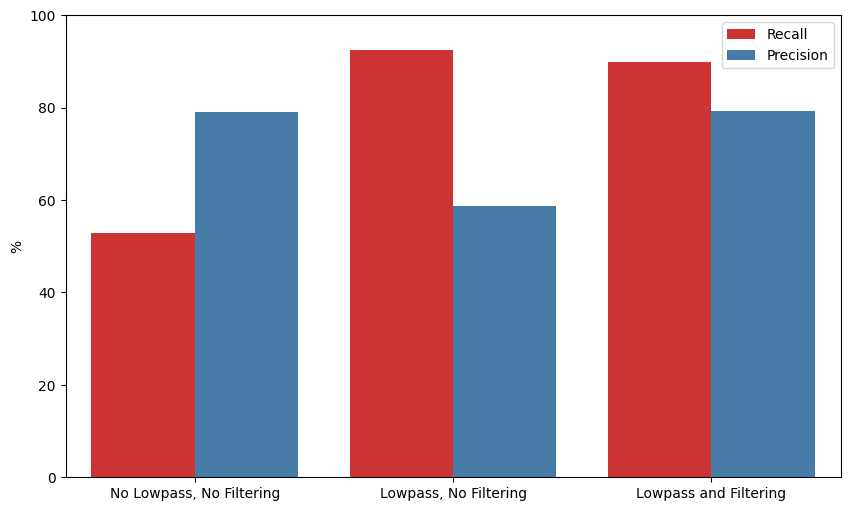

In [66]:
# Make a bar graph for the poster

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
data = {
    'Category': ['No Lowpass, No Filtering', 'No Lowpass, No Filtering', 'Lowpass, No Filtering', 'Lowpass, No Filtering', 'Lowpass and Filtering', 'Lowpass and Filtering'],
    'Group': ['Recall', 'Precision', 'Recall', 'Precision', 'Recall', 'Precision'],
    'Value': 100*np.array([0.5288413066174151, 0.7909151693874147, 0.9259140062984508, 0.5880396069323136, 0.898052087119606, 0.7937512947738707]),
    'Error': [0.14954439124898108, 0.08415876305686014, 0.05774705786948508, 0.0817208828768312, 0.06632071635290356, 0.06550005777509982]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
g = sns.barplot(x='Category', y='Value', hue='Group', data=df, palette='Set1')
plt.xlabel(None)
plt.ylabel("%")
plt.ylim(0, 100) 
g.legend_.set_title(None)
plt.savefig('my_high_res_figure.png', dpi=600)

plt.show()



In [ ]:
import numpy as np

# Expanding the sample data to include multiple values for each group
expanded_data = {
    'Category': ['Category A']*6 + ['Category B']*6 + ['Category C']*6,
    'Group': ['Group 1', 'Group 1', 'Group 1', 'Group 2', 'Group 2', 'Group 2']*3,
    'Value': np.random.randint(10, 20, 6).tolist() + 
             np.random.randint(20, 30, 6).tolist() +
             np.random.randint(30, 40, 6).tolist()
}

# Creating an expanded DataFrame
expanded_df = pd.DataFrame(expanded_data)

# Plotting with error bars (standard deviation)
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Value', hue='Group', data=expanded_df, ci='sd')
plt.title('Bar Graph with Error Bars (Standard Deviation)')
plt.show()
